In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Flatten,
    Conv1D, MaxPooling1D,
    LSTM, GRU,
    Dropout, BatchNormalization
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# -----------------------------
# 1) 파일 로드 함수 정의
# -----------------------------

def load_file(filepath):
    """공백(whitespace)으로 구분된 txt 파일을 읽어서 numpy 배열로 변환"""
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_group(filenames, prefix=''):
    """여러 센서 파일을 불러와서 (샘플, 타임스텝, 특성) 형태의 3D 배열로 결합"""
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    """train/test 그룹별로 9개 센서 신호 + 라벨 로드"""
    filepath = prefix + '/' + group + '/Inertial Signals/'

    filenames = []
    # 총가속도
    filenames += ['total_acc_x_' + group + '.txt',
                  'total_acc_y_' + group + '.txt',
                  'total_acc_z_' + group + '.txt']
    # 신체가속도
    filenames += ['body_acc_x_' + group + '.txt',
                  'body_acc_y_' + group + '.txt',
                  'body_acc_z_' + group + '.txt']
    # 자이로스코프
    filenames += ['body_gyro_x_' + group + '.txt',
                  'body_gyro_y_' + group + '.txt',
                  'body_gyro_z_' + group + '.txt']

    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + '/y_' + group + '.txt')
    return X, y

In [3]:
def load_dataset(prefix=''):
    """전체 train / test 데이터셋 로드 + 원-핫 인코딩"""
    base_path = prefix + '/content/drive/MyDrive/ml-programming-lab/week10/UCI HAR Dataset'

    trainX, trainy = load_dataset_group('train', base_path)
    testX, testy = load_dataset_group('test', base_path)

    # 라벨을 0 ~ 5로 맞추기 (원래 1~6)
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)

    print("trainX:", trainX.shape,
          "trainy:", trainy.shape,
          "trainy_one_hot:", trainy_one_hot.shape)
    print("testX:", testX.shape,
          "testy:", testy.shape,
          "testy_one_hot:", testy_one_hot.shape)

    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [4]:
# -----------------------------
# 2) 데이터 로드 + 스케일링
# -----------------------------

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset(prefix='')

print(f"원본 trainX shape: {trainX.shape}, testX shape: {testX.shape}")

# --- 스케일링 ---
scaler = StandardScaler()
trainX_reshaped = trainX.reshape((trainX.shape[0], -1))
testX_reshaped  = testX.reshape((testX.shape[0], -1))
trainX_scaled = scaler.fit_transform(trainX_reshaped).reshape(trainX.shape)
testX_scaled  = scaler.transform(testX_reshaped).reshape(testX.shape)

# --- Train / Validation Split ---
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX_scaled, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

/tmp/ipython-input-1685226877.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1685226877.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1685226877.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-1685226877.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


trainX: (7352, 128, 9) trainy: (7352, 1) trainy_one_hot: (7352, 6)
testX: (2947, 128, 9) testy: (2947, 1) testy_one_hot: (2947, 6)
원본 trainX shape: (7352, 128, 9), testX shape: (2947, 128, 9)


In [5]:
# -----------------------------
# 3) 입력 차원 및 클래스 개수 설정
# -----------------------------

n_timesteps = X_train.shape[1]
n_features  = X_train.shape[2]
n_outputs   = y_train_one_hot.shape[1]

print("n_timesteps:", n_timesteps)
print("n_features :", n_features)
print("n_outputs  :", n_outputs)

n_timesteps: 128
n_features : 9
n_outputs  : 6


In [11]:
# -----------------------------
# 4) CNN + GRU 모델 정의 및 학습
# -----------------------------

# 모델 정의
cnn_gru_model = Sequential([
    # Conv 블록 1
    Conv1D(128, kernel_size=5, activation='relu', padding='same',
           input_shape=(n_timesteps, n_features)),
    BatchNormalization(),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Conv 블록 2
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # GRU
    GRU(128, return_sequences=False),
    Dropout(0.5),

    # Dense
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs, activation='softmax')
])

# 모델 컴파일
cnn_gru_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# 모델 구조 요약
cnn_gru_model.summary()

# 콜백 설정 (조기 종료 + 학습률 감소)
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-5
    )
]

# 모델 학습
history_cnn_gru = cnn_gru_model.fit(
    X_train, y_train_one_hot,
    epochs=100,          # 30 → 100 (EarlyStopping이 알아서 멈춤)
    batch_size=64,       # 32 → 64
    validation_data=(X_val, y_val_one_hot),
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 128, 128)       │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 128, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 64, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,054 (1.35 MB)

 Trainable params: 353,030 (1.35 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5927 - loss: 0.9892 - val_accuracy: 0.8593 - val_loss: 0.4184 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8987 - loss: 0.2748 - val_accuracy: 0.9286 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9430 - loss: 0.1617 - val_accuracy: 0.9388 - val_loss: 0.1340 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9434 - loss: 0.1423 - val_accuracy: 0.9504 - val_loss: 0.1229 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9495 - loss: 0.1255 - val_accuracy: 0.9517 - val_loss: 0.1176 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9475 - loss: 0.1306 - val_accuracy: 0.9477 - val_loss: 0.1116 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9494 - loss: 0.1171 - 

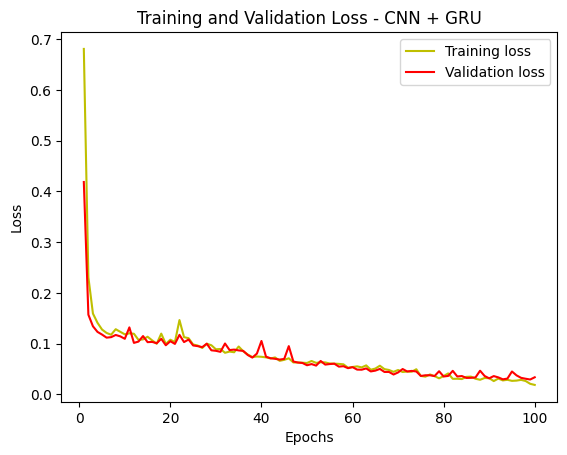

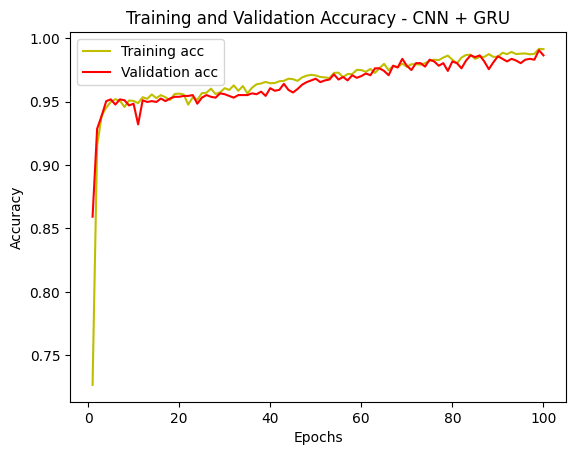

In [12]:
# -----------------------------
# 5) 학습 곡선 시각화
# -----------------------------

# 학습 손실 곡선
loss = history_cnn_gru.history['loss']
val_loss = history_cnn_gru.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - CNN + GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 학습 정확도 곡선
acc = history_cnn_gru.history['accuracy']
val_acc = history_cnn_gru.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy - CNN + GRU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Confusion Matrix:
 [[467   0  29   0   0   0]
 [  0 447  11  13   0   0]
 [  0   0 420   0   0   0]
 [  0  24   0 416  51   0]
 [  0   1   0  30 501   0]
 [  0   0   0   0   0 537]]

Accuracy: 0.9460468272819816

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97       496
           1       0.95      0.95      0.95       471
           2       0.91      1.00      0.95       420
           3       0.91      0.85      0.88       491
           4       0.91      0.94      0.92       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



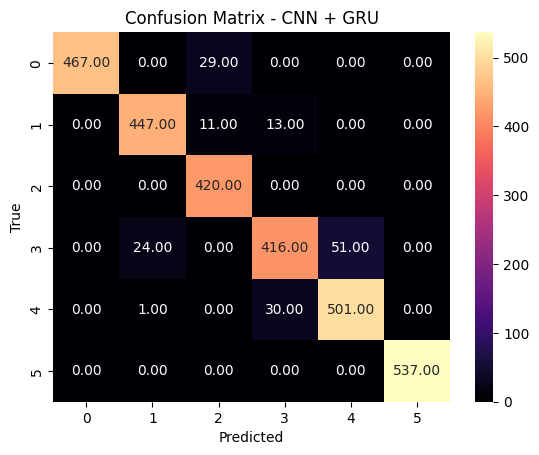

In [13]:
# -----------------------------
# 6) 모델 평가
# -----------------------------

# 테스트 데이터 예측
pred = cnn_gru_model.predict(testX_scaled)
pred = np.argmax(pred, axis=-1)

# 혼동 행렬 및 정확도 출력
cm = confusion_matrix(testy, pred)
print("Confusion Matrix:\n", cm)
print("\nAccuracy:", accuracy_score(testy, pred))
print("\nClassification Report:\n", classification_report(testy, pred))

# 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='.2f', cmap='magma')
plt.title('Confusion Matrix - CNN + GRU')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
# -----------------------------
# 7) 5-Fold 교차 검증
# -----------------------------

print("\n===== 5-Fold Cross Validation (CNN + GRU) =====")

# 전체 train 세트 사용
X_all = trainX_scaled              # (전체 학습 입력)
y_all_int = trainy.flatten()       # 정수 라벨 (0~5)
y_all_one_hot = trainy_one_hot     # 원-핫 라벨

# 폴드 분할 설정 (라벨 비율 유지)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증용 모델 생성 함수
def create_cnn_gru_model():
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)),
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        GRU(128),
        Dense(64, activation='relu'),
        Dense(n_outputs, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

fold_no = 1
cv_acc_list = []

for train_idx, val_idx in kfold.split(X_all, y_all_int):
    print(f"\n▶ Fold {fold_no}")

    # 폴드별 train / val 나누기
    X_tr, X_vl = X_all[train_idx], X_all[val_idx]
    y_tr, y_vl = y_all_one_hot[train_idx], y_all_one_hot[val_idx]

    # 폴드마다 새로운 모델 생성
    model_cv = create_cnn_gru_model()

    # 학습 (조금 줄여서 20 epoch 정도)
    history_cv = model_cv.fit(
        X_tr, y_tr,
        epochs=20,
        batch_size=32,
        validation_data=(X_vl, y_vl),
        verbose=0
    )

    # 검증 성능 평가
    loss_cv, acc_cv = model_cv.evaluate(X_vl, y_vl, verbose=0)
    print(f"Fold {fold_no} - val_loss: {loss_cv:.4f}, val_acc: {acc_cv:.4f}")

    cv_acc_list.append(acc_cv)
    fold_no += 1

print("\n===== Cross Validation Result (CNN + GRU) =====")
print("Fold Accuracies:", [f"{a:.4f}" for a in cv_acc_list])
print(f"Mean Accuracy: {np.mean(cv_acc_list):.4f} ± {np.std(cv_acc_list):.4f}")


===== 5-Fold Cross Validation (CNN + GRU) =====

▶ Fold 1


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fold 1 - val_loss: 0.0621, val_acc: 0.9694

▶ Fold 2
Fold 2 - val_loss: 0.0628, val_acc: 0.9667

▶ Fold 3
Fold 3 - val_loss: 0.0682, val_acc: 0.9646

▶ Fold 4
Fold 4 - val_loss: 0.0786, val_acc: 0.9687

▶ Fold 5
Fold 5 - val_loss: 0.0765, val_acc: 0.9673

===== Cross Validation Result (CNN + GRU) =====
Fold Accuracies: ['0.9694', '0.9667', '0.9646', '0.9687', '0.9673']
Mean Accuracy: 0.9674 ± 0.0017
